# Data Retrieval

We start by retrieving the trending hashtags in Delhi, followed by collecting 10,000 tweets (filtering out retweets as they do not usually contain new information) containing the chosen hashtag, *#FarmersDoneWithModiJumlas*.

The code below is written keeping in mind the rate limits of the Twitter API, and also handles external dependencies such as mising corpuses, files and directories. Please skip this section if you already have the tweets saved as a JSON file.

In [11]:
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from tqdm import tqdm
from pprint import pprint
import json
import plotly.express as px
import plotly.figure_factory as pff
import plotly.offline as poff
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re, os

In [21]:
############     ADD YOUR KEYS AND    ############
############ ADJUST OUTPUT PATHS HERE ############

CONSUMER_KEY = ""
CONSUMER_KEY_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
PATH_OUT = '../../out/task-2/'

os.makedirs(os.path.join(PATH_OUT, 'plots'), exist_ok=True)
poff.init_notebook_mode(connected=True)
mpl.rcParams['figure.dpi'] = 100

In [4]:
auth = tweepy.AppAuthHandler(CONSUMER_KEY, CONSUMER_KEY_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Get the locations with trend data available and find Delhi's place ID. Then, pull out hashtags trending in Delhi and pick one.

In [ ]:
places = api.trends_available()
pprint(places)

# found afterwards
DELHI_PLACE_ID = 20070458

In [ ]:
trends = api.trends_place(id=DELHI_PLACE_ID)[0]
for trend in trends['trends']:
    print(trend['name'], trend['tweet_volume'])
with open(os.path.join(PATH_OUT, 'trends.json'), 'w') as f:
    json.dump(trends, f)

# found afterwards
TRENDING_HASHTAG = '#FarmersDoneWithModiJumlas'

Get tweets with the chosen hashtag, filtering out retweets. This might take a while.

In [33]:
def loop_twitter(cursor, limit):
    res = []
    for obj in tqdm(cursor.items(limit)):
        # tweepy automatically stalls on rate limit
        res.append(obj)
    return(res)

def full_display(df):
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.width', 150)
    pd.set_option('display.max_colwidth', None)
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

In [11]:
query = f'{TRENDING_HASHTAG} -filter:retweets'
limit = 10000
cursor = tweepy.Cursor(api.search, q=query)
main_tweets = loop_twitter(cursor, limit)

5891it [05:52, 17.42it/s]Rate limit reached. Sleeping for: 547
10000it [19:15,  8.66it/s]


In [14]:
main_tweets_json = [t._json for t in main_tweets]

# save in both encodings, lots of indic characters and emoji expected
with open(os.path.join(PATH_OUT, 'main_tweets_utf.json'), 'w', encoding='utf-8') as f:
    json.dump(main_tweets_json, f, ensure_ascii=False)
    
with open(os.path.join(PATH_OUT, 'main_tweets_ascii.json'), 'w') as f:
    json.dump(main_tweets_json, f)

# Analysis

Here, we perform an exploratory analysis of the given data, focussing on the language, regions and sentiments of the tweets and attributes (such as count of followers) that determine the popularity or activity of the users who posted them.

In [9]:
with open(os.path.join(PATH_OUT, 'main_tweets_utf.json'), 'r', encoding='utf-8') as f:
    main_tweets_json = json.load(f)
df = pd.DataFrame.from_records(main_tweets_json)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 10000 non-null  object 
 1   id                         10000 non-null  int64  
 2   id_str                     10000 non-null  object 
 3   text                       10000 non-null  object 
 4   truncated                  10000 non-null  bool   
 5   entities                   10000 non-null  object 
 6   metadata                   10000 non-null  object 
 7   source                     10000 non-null  object 
 8   in_reply_to_status_id      1942 non-null   float64
 9   in_reply_to_status_id_str  1942 non-null   object 
 10  in_reply_to_user_id        2030 non-null   float64
 11  in_reply_to_user_id_str    2030 non-null   object 
 12  in_reply_to_screen_name    2030 non-null   object 
 13  user                       10000 non-null  obje

## Tweet Language

First, we plot the language distribution of the tweets. The language labels are automatically assigned by Twitter based on the tweet text, and hence may not always be accurate. Several examples containing Hinglish text could be found on a random sampling of the dataset, which were incorrectly categorised as English.

We find that almost a fourth of the tweets were not categorised (`und` or *undefined*), and according to Twitter, they consist of texts that only contain entity names, emojis, URLS, twitter handles, gibberish or content that the classification model failed to recognise as any language.

English, Punjabi and Hindi form a significant portion of the categorised tweets, which is expected, given that the hashtag refers to a social event (recent protests by farmers in Punjab and Haryana against changes to agricultural laws) pertaining to Northern India. Delhi, being the seat of the Parliament, was the epicenter of the protest, which explains why this hashtag was trending in Delhi.

**Note:** *The below plot is interactive. Clicking on the legend removes categories from the composition calculation. A similar plot can be found on [twisualise](https://twisualise.herokuapp.com).*

In [13]:
lang_counts = df.groupby('lang')['id'].count().to_frame().reset_index()
lang_counts.columns = ['lang', 'count']
lang_counts.sort_values(by='count', inplace=True, ascending=False)
lang_counts.iloc[10:, :].loc[:, 'lang'] = 'other'
fg = px.pie(lang_counts, values='count', names='lang', title='Tweets by Language')
fg.write_image(os.path.join(PATH_OUT, 'plots/language-dist.svg'))
fg.show()

## User Attributes

We now focus on the attributes of the users posting these tweets. Each tweet object contains information about the associated user, and we identified 3286 unique users. Apart from the readily available attributes such as the friend and follower counts of the users, we aggregate some more, such as the average number of likes or retweets received by their tweets in the dataset.

We then plot a correlation heatmap of these attributes, looking for patterns such as *do users with lots of followers also follow lots of people* or *are tweets of users with lots of followers retweeted more often*. We also look at the role played by Twitter's *verified* user status.

We only find a strong correlation between the `user_statuses_count` (total number of tweets posted) and each of `user_favorites_count` (number of tweets marked as favorite) and `user_listed_count` (number of public lists the user is a member of) indicating that amount of user activity shows across all forms of interactions Twitter allows (more active users have more tweets, favorites and appear on more lists and vice versa).

Quite intuitively, tweets that are retweeted more are also liked more - which probably indicates that the tweet was 'good' and is also reminiscent of Twitter's algorithms that show already popular tweets at the top of the feed, increasing their chances of being further retweeted or liked.

There is surprisingly very little correlation between the number of friends (number of people followed) and followers of a user. Some correlation between the number of followers and the verified status confirms that the status does add to the authenticity of the user, though only to some extent.

**Note:** *Twitter does not require a minimum threshold for any of the above values for granting the 'verified' status. The 'activity' requirement only considers the last login date.*

**Note:** *Plots showing the distribution of friends and followers of users are available on [twisualise](https://twisualise.herokuapp.com/). We find that most users have less than 1000 friends, though the number of followers is slightly larger.*

In [15]:
filtered_df = df[['id', 'retweet_count', 'favorite_count', 'user', 'created_at', 'text']]
filtered_df = filtered_df.assign(user_id=lambda x: x.user.apply(lambda y: y['id']),
                   user_followers_count=lambda x: x.user.apply(lambda y: y['followers_count']),
                   user_friends_count=lambda x: x.user.apply(lambda y: y['friends_count']),
                   user_favorites_count=lambda x: x.user.apply(lambda y: y['favourites_count']),
                   user_verified=lambda x: x.user.apply(lambda y: y['verified']),
                   user_listed_count=lambda x: x.user.apply(lambda y: y['listed_count']),
                   user_statuses_count=lambda x: x.user.apply(lambda y: y['statuses_count']),
                   user_created_at=lambda x: x.user.apply(lambda y: y['created_at']))

In [16]:
user_df = filtered_df[['user_id', 'user_followers_count', 'user_friends_count', 'user_favorites_count', 'user_listed_count', 'user_verified', 'user_statuses_count', 'user_created_at']].drop_duplicates(subset='user_id', ignore_index=True)
user_df.set_index(keys='user_id', inplace=True, verify_integrity=True)

In [17]:
agg_df = filtered_df[['user_id', 'retweet_count', 'favorite_count']]
agg_df = agg_df.groupby('user_id').agg('mean')
agg_df.columns = ['avg_retweet_count', 'avg_favorite_count']

In [18]:
user_df = user_df.join(agg_df, how='inner')
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 861721644 to 1333550433692839936
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_followers_count  3286 non-null   int64  
 1   user_friends_count    3286 non-null   int64  
 2   user_favorites_count  3286 non-null   int64  
 3   user_listed_count     3286 non-null   int64  
 4   user_verified         3286 non-null   bool   
 5   user_statuses_count   3286 non-null   int64  
 6   user_created_at       3286 non-null   object 
 7   avg_retweet_count     3286 non-null   float64
 8   avg_favorite_count    3286 non-null   float64
dtypes: bool(1), float64(2), int64(5), object(1)
memory usage: 234.3+ KB


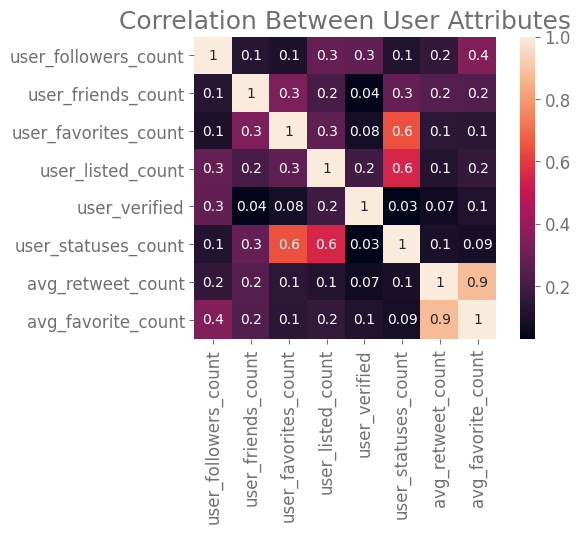

In [22]:
ax = sns.heatmap(user_df.corr(), annot=True, fmt='.1g', square=True)
ax.set_title('Correlation Between User Attributes')
fg = ax.get_figure()
fg.patch.set_facecolor('white')
fg.savefig(os.path.join(PATH_OUT, 'plots/user-corr.png'), dpi=200, bbox_inches='tight')
plt.show()

## Sentiment Analysis

Here we perform a sentiment analysis of the tweet text, using the **Vader Lexicon** model, which is specifically fine-tuned to handling texts from social media (characterised by abundant use of emojis, slangs, expressive words and grammatically incomplete sentences).

Due to the limitations of the model, we only consider tweets in the English language, and clean out URLS and usernames. Punctuations, stopwords and emojis are allowed to stay, because they heavily influence the sentiment of texts on social media, and Vader Lexicon is tuned to take them into consideration.

The time series of tweet sentiments on the morning/afternoon (IST) of 19 December 2020 is plotted below (times in UTC). We find that roughly a third of the tweets are positive while a third are negative. A closer look at the tweet texts shows that several positive tweets express support for the farmers (for example, "We stand with our farmers.") while the negative ones express distaste towards the new laws or the lawmakers.

**Note:** *Randomly picked examples of tweets categorised as positive and negative can be found on [twisualise](https://twisualise.herokuapp.com/). Because these tweets are picked from a large corpus of 2612 English language tweets, there are bound to be some misclassifications. Reload the page to see a different example.*

In [23]:
text_df = df[['text', 'lang', 'id', 'created_at']]
text_df['created_at'] = pd.to_datetime(text_df['created_at'])
text_df = text_df[text_df.lang == 'en']
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 6 to 9996
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        2612 non-null   object             
 1   lang        2612 non-null   object             
 2   id          2612 non-null   int64              
 3   created_at  2612 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 102.0+ KB


In [24]:
try:
    senti = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    senti = SentimentIntensityAnalyzer()

In [25]:
def filter_pattern(text, pattern):
    match = re.findall(pattern, text)
    for m in match:
        text = re.sub(m, ' ', text)
    return text

TWITTER_HANDLE_REGEX = '@\\w{1,15}'
URL_REGEX = 'https?://[A-Za-z0-9./]*'

text_df['text'] = text_df['text'].apply(filter_pattern, args=(TWITTER_HANDLE_REGEX, ))
text_df['text'] = text_df['text'].apply(filter_pattern, args=(URL_REGEX, ))

In [26]:
def calc_sentiment(text, senti):
    res = senti.polarity_scores(text)
    return res['neg'], res['neu'], res['pos'], res['compound']

scores = text_df['text'].apply(calc_sentiment, args=(senti, )).apply(pd.Series)
scores.columns = ['negative', 'neutral', 'positive', 'compound']
text_df = text_df.join(scores, how='left') # on default index

In [27]:
def categorise_sentiment(val):
    # based on official paper: https://github.com/cjhutto/vaderSentiment#about-the-scoring
    if val >= 0.05:
        return 'Positive'
    elif val > -0.05:
        return 'Neutral'
    else:
        return 'Negative'

text_df['sentiment'] = text_df['compound'].apply(categorise_sentiment)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 6 to 9996
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   text        2612 non-null   object             
 1   lang        2612 non-null   object             
 2   id          2612 non-null   int64              
 3   created_at  2612 non-null   datetime64[ns, UTC]
 4   negative    2612 non-null   float64            
 5   neutral     2612 non-null   float64            
 6   positive    2612 non-null   float64            
 7   compound    2612 non-null   float64            
 8   sentiment   2612 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(3)
memory usage: 284.1+ KB


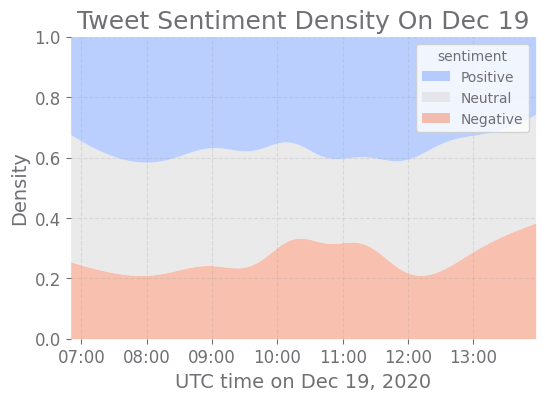

In [29]:
ax = sns.kdeplot(data=text_df, x='created_at', hue='sentiment', multiple='fill', linewidth=0, alpha=0.6, palette='coolwarm', hue_order=('Positive', 'Neutral', 'Negative'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
ax.set_xlabel('UTC time on Dec 19, 2020')
ax.set_title('Tweet Sentiment Density On Dec 19')
fg = ax.get_figure()
fg.patch.set_facecolor('white')
fg.savefig(os.path.join(PATH_OUT, 'plots/sentiment-density.png'), dpi=200)
plt.show()

Text of some of the positively classified tweets.

In [34]:
full_display(text_df[text_df.sentiment == 'Positive']['text'])

6                                                                                  Support farmers\n#FarmersDoneWithModiJumlas  
58                                                              So funny ..... Please stop this....😃#FarmersDoneWithModiJumlas  
69                                                                         KEEP SUPPORTING FARMERS✊🌾\n#FarmersDoneWithModiJumlas
76      If the agriculture bill is for the benefit of farmers, then why is Adani promoting it ??\n\n That too by giving crore…  
91                                                                        Stay strong, stay united\n#FarmersDoneWithModiJumlas  
                                                                  ...                                                           
9932                                                                     Thanks for Supporting Sir\n#FarmersDoneWithModiJumlas  
9933                                                                                   Good one \

## Tweet Locations

We now focus on the locations from where these tweets were made. Location data was available for only 249 of the tweets, and is generated by Twitter either using the upload point location, or if that's not available, using the location mentioned in the user's profile.

We bin the locations into 30 hexagons using geographical proximity and plot on a world map. Naturally, the action is epicentered in North India, with some tweets coming from Canada and Australia.

**Note:** *The below map is interactive. A map showing individual tweet locations can also be found on [twisualise](https://twisualise.herokuapp.com/).*

In [35]:
def get_centroid(place):
    return np.array(place['bounding_box']['coordinates'][0], dtype=np.float64).mean(axis=0)

place_df = df[df.place.notnull()]['place']
centroid_df = place_df.apply(get_centroid).apply(pd.Series)
centroid_df.columns = ['longitude', 'latitude']
fig = pff.create_hexbin_mapbox(data_frame=centroid_df, lat='latitude', lon='longitude', labels={'color': 'Tweet Count'}, opacity=0.69, nx_hexagon=30, min_count=1, color_continuous_scale='emrld', title='Tweet Locations')
fig.update_layout(mapbox_style='open-street-map')
fig.write_image(os.path.join(PATH_OUT, 'plots/locations.svg'))
fig.show()